In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

2023-04-20 09:00:59.586348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 09:00:59.586369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset preparation

Dataset downloaded from: https://www.kaggle.com/datasets/patriciabrezeanu/big-cats-image-classification-dataset?resource=download

## Reading color images

In [2]:
import splitfolders 
splitfolders.ratio('animals', output="output", seed=1337, ratio=(.8, 0.2))

In [3]:
labels = ['cheetah', 'leopard', 'lion', 'tiger']
img_size = 512

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
color_train = get_data('output/train')
color_val = get_data('output/val')

/tmp/ipykernel_3194444/2378813345.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


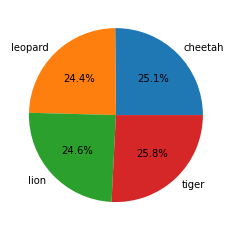

(589, 2)


In [5]:
y = np.array([np.count_nonzero(color_train[:,1] == 0), np.count_nonzero(color_train[:,1] == 1), np.count_nonzero(color_train[:,1] == 2), np.count_nonzero(color_train[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_train.shape)

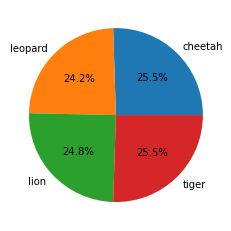

(149, 2)


In [6]:
y = np.array([np.count_nonzero(color_val[:,1] == 0), np.count_nonzero(color_val[:,1] == 1), np.count_nonzero(color_val[:,1] == 2), np.count_nonzero(color_val[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_val.shape)

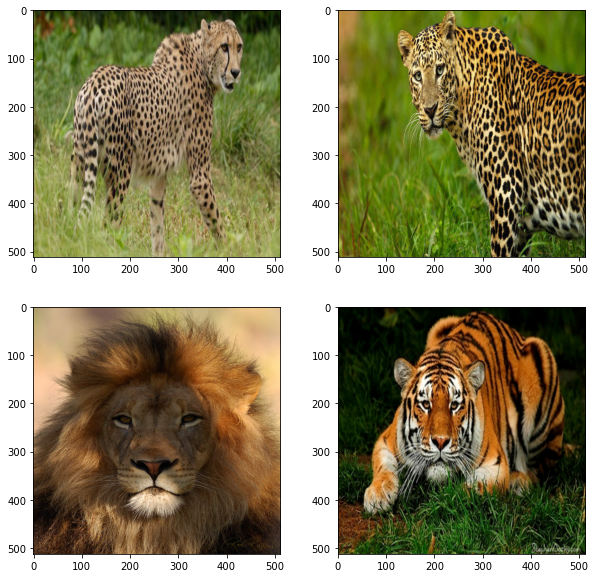

In [7]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(color_train[1][0])
axes[0, 1].imshow(color_train[160][0])
axes[1, 0].imshow(color_train[300][0])
axes[1, 1].imshow(color_train[450][0])


# Grayscale image preparation

In [8]:
def get_gray_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                data.append([gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
gray_train = get_gray_data('output/train')
gray_val = get_gray_data('output/val')

/tmp/ipykernel_3194444/109414422.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


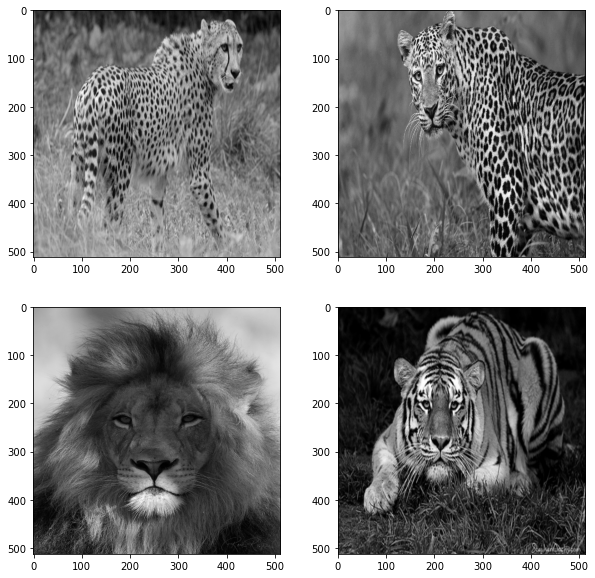

In [10]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_train[450][0], cmap='gray')

# Noise filtering

In [11]:
def get_gray_filtered_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [12]:
gray_filtered_train = get_gray_filtered_data('output/train')
gray_filtered_val = get_gray_filtered_data('output/val')

/tmp/ipykernel_3194444/3179082502.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


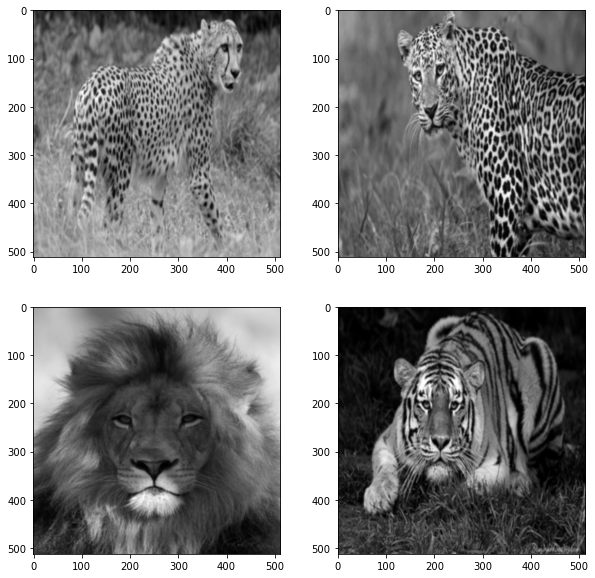

In [13]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_filtered_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_filtered_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_filtered_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_filtered_train[450][0], cmap='gray')

# Dataset expansion

In [14]:
from skimage.exposure import adjust_gamma

In [15]:
def get_expanded_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_left_right(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_up_down(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                image_dark = adjust_gamma(resized_arr, gamma=2,gain=1)
                gray = cv2.cvtColor(np.float32(image_dark), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
            except Exception as e:
                print(e)
    return np.array(data)

In [16]:
expanded_train = get_expanded_data('output/train')
expanded_val = get_expanded_data('output/val')

2023-04-20 09:02:28.615060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/arnas/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-20 09:02:28.615213: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 09:02:28.615290: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arnas-desktop): /proc/driver/nvidia/version does not exist
2023-04-20 09:02:28.616184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_319

In [17]:
print(expanded_train.shape)
print(expanded_val.shape)

(2356, 2)
(596, 2)


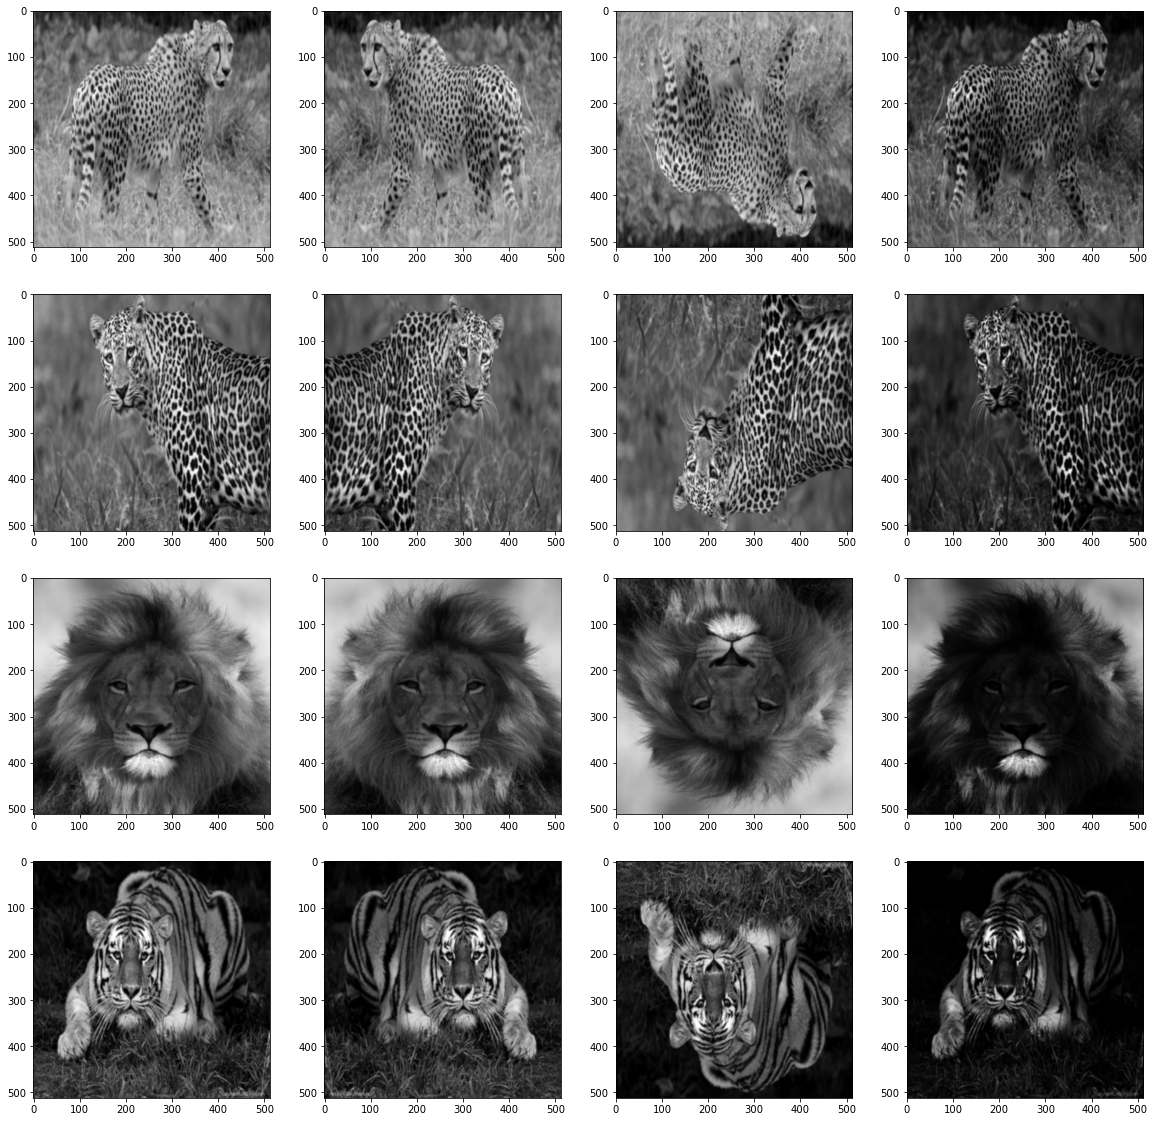

In [18]:
rows=4
cols = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

axes[0, 0].imshow(expanded_train[4][0], cmap='gray')
axes[0, 1].imshow(expanded_train[5][0], cmap='gray')
axes[0, 2].imshow(expanded_train[6][0], cmap='gray')
axes[0, 3].imshow(expanded_train[7][0], cmap='gray')

axes[1, 0].imshow(expanded_train[640][0], cmap='gray')
axes[1, 1].imshow(expanded_train[641][0], cmap='gray')
axes[1, 2].imshow(expanded_train[642][0], cmap='gray')
axes[1, 3].imshow(expanded_train[643][0], cmap='gray')

axes[2, 0].imshow(expanded_train[1200][0], cmap='gray')
axes[2, 1].imshow(expanded_train[1201][0], cmap='gray')
axes[2, 2].imshow(expanded_train[1202][0], cmap='gray')
axes[2, 3].imshow(expanded_train[1203][0], cmap='gray')

axes[3, 0].imshow(expanded_train[1800][0], cmap='gray')
axes[3, 1].imshow(expanded_train[1801][0], cmap='gray')
axes[3, 2].imshow(expanded_train[1802][0], cmap='gray')
axes[3, 3].imshow(expanded_train[1803][0], cmap='gray')

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/